In [ ]:
import wave
import os
import glob
import soundfile as sf
from scipy.signal import spectrogram, butter, lfilter, decimate, hilbert, resample
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

    
VOLUME_AMP_MULTIPLE = 20
NPERSEG = 256
NOVERLAP = int(NPERSEG * 0.25)
WINDOW = 'hanning'
SPECTROGRAM_RAW_LOW = 1
SPECTROGRAM_RAW_HIGH = 4
SPECTROGRAM_POWER_FACTOR = 4
LOWCUT = 4500
HIGHCUT = 9500
SPECTROGRAM_HEIGHT = int(64)
morph_elem = 0
morph_size = 0
morph_operator = 0
element=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))

def fade_in(data, samples):
    samples=math.ceil(samples)
    g=np.linspace(0,1,samples)
    data[: samples]=np.multiply(data[:samples],g)
    return data;

def fade_out(data, samples):
    samples=math.ceil(samples)
    g=np.linspace(1,0,samples)
    data[(len(data)-samples) :]=np.multiply(data[(len(data)-samples) :],g)
    return data;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def getEnvelope(inputSignal,intervalLength):
    absoluteSignal = []
    print('getting envelope..')
    for sample in inputSignal:
        absoluteSignal.append (abs (sample))
    outputSignal = []
    for baseIndex in range (0, len (absoluteSignal)):
        maximum = 0
        for lookbackIndex in range (intervalLength):
            maximum = max (absoluteSignal [baseIndex - lookbackIndex], maximum)
        outputSignal.append (maximum)
    print('done getting envelope..')
    return outputSignal 


def wav_to_spectrogram(data, samplerate): 
    #makes spectrogram, resizes to 100 square, flattens    
    f, t, spec = spectrogram(data,fs=float(samplerate),window=WINDOW,nperseg=NPERSEG,noverlap=NOVERLAP,mode='magnitude')    
    sel=np.where(np.logical_and(f>=5000, f<=10000))
    spec=spec[sel][:]
    spec=np.flipud(spec)
    spec=spec+0.0001
    #spec(np.nonzero(spec))=spec(np.nonzero(spec)))
    spec=np.log10(spec)*20
    spec = cv2.resize(spec, (100, 100))  
    norm_image = np.zeros((100,100))
    cv2.normalize(spec, norm_image, 0, 1, norm_type=cv2.NORM_MINMAX)
    print(np.min(norm_image), np.max(norm_image))
    tmp = norm_image.reshape(1,10000)
    p = np.percentile(tmp, 85)
    th, im_th = cv2.threshold(norm_image, p, 1, cv2.THRESH_TOZERO)
    #im=im_th
    im = im_th.reshape(1,10000)    
    return im;    
    

#define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)    
    
    
def load_wavs(directory):
    os.chdir(directory)
    wavefiles = glob.glob('*.wav')
    imstack=pd.DataFrame()
    for idx, wavefile in enumerate(wavefiles):
        data, samplerate = sf.read(wavefile) 
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate)
        target_length=round(samplerate*0.5)
        actual_length=len(data)
        difference=target_length-actual_length
        d=round(difference/2)
    
        if(d>0):
            data=np.pad(data, (d, d), 'constant')
        if(d<0):
            d=d*-1
            data=data[d :]
            q=len(data)-d
            data=data[: q]  
    
        f, t, spec = spectrogram(data,fs=float(samplerate),window=WINDOW,nperseg=NPERSEG,noverlap=NOVERLAP,mode='magnitude')
        spec=np.flipud(spec)
        spec=spec[:45][:]
        spec = cv2.resize(spec, (100, 100))   
        p = np.percentile(spec, 98)
        th, im_th = cv2.threshold(spec, p, 1, cv2.THRESH_BINARY)
        im = im_th.reshape(1,10000)
        if idx==0:
            imstack=im
        if idx>0:
            imstack=np.append(imstack,im,axis=0)   
    return imstack, idx;

def max_rolling1(a, window,axis =1):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolling = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return np.max(rolling,axis=axis)

def load_wavs_chop(filename):
    wavefiles = glob.glob('*.wav')
    data, samplerate = sf.read(filename)
    data=data*100
    data=butter_bandpass_filter(data, 4000, 10000, samplerate, order=5)
    
    plt.plot(data[:round(0.5*samplerate)])# plotting the graph
   
    data_ds=decimate(data, 4)
    samplerate_ds=int(samplerate/4)
    data_ds=data
    samplerate_ds=samplerate
    
    analytic_signal = hilbert(data_ds)
    amplitude_envelope = np.abs(analytic_signal)
    #amplitude_envelope = moving_avg(amplitude_envelope,500)
    amplitude_envelope = max_rolling1(amplitude_envelope,200)
    #amplitude_envelope=getEnvelope(data_ds,400)
    #plt.plot(amplitude_envelope)# plotting the graph
    #plt.show() #Displaying the figures
    call=np.zeros(len(amplitude_envelope), dtype=float, order='C')
    #print(len(call))
    envelope_threshold=np.percentile(amplitude_envelope, 20)
    envelope_threshold=0.02
    for i in range(0, len(call)):
        if(amplitude_envelope[i]>envelope_threshold):
            call[i]=1
    #a=resample(call, len(call)*4)
    a=call
    plt.plot(a[:round(0.5*samplerate)])   
    plt.plot(amplitude_envelope[:round(0.5*samplerate)])
    plt.show() #Displaying the figures 
    
    return call, data, data_ds, samplerate_ds, samplerate;        
   
def show_spectrograms(imstack, idx):
    rows=math.ceil(math.sqrt(idx+1))
    cols=rows
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))  
    for idx, wavefile in enumerate(wavefiles):
        im=imstack[idx][:].reshape(100,100)
        #ax.ravel()[idx].imshow(im,cmap='binary')
        ax.ravel()[idx].imshow(im,cmap='gray')
        ax.ravel()[idx].set_title(wavefiles[idx])
        ax.ravel()[idx].set_axis_off()
    plt.show()  
    
    
def show_spectrograms_column(imstack, idx):
    rows=idx+1
    cols=1
    fig, ax = plt.subplots(nrows=rows, ncols=cols ) 

    for idx, wavefile in enumerate(wavefiles):
        im=imstack[idx][:].reshape(100,100)
        #ax.ravel()[idx].imshow(im,cmap='binary')
        ax.ravel()[idx].imshow(im)
        ax.ravel()[idx].set_title(wavefiles[idx])
        ax.ravel()[idx].set_axis_off()
    fig.tight_layout()
    plt.show()      

def set_to_target_length(data,target_length):
    q=len(data)-target_length
    #print(data.shape)
    #print(target_length, len(data), q)
    if(q==0):
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate)
    if q<0:
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate)
        data=np.append(data,np.zeros(abs(q)))
        #print('q<0, ',  len(data))
    if q>0:
        data=data[:target_length]
        data=fade_in(data,0.005*samplerate)
        data=fade_out(data,0.005*samplerate) 
        #print('q>0, ', len(data))
    return data;
     
def calls_to_new_call_list(call,samplerate, samplerate_ds):   
    cnt=-1
    previous_one=0
    callstart_sec=[]
    callstop_sec=[]
    callduration_sec=[]
    for i, c in enumerate(call):
        if i==0:
            previous_one=0
            c=0
        if i>0:
            if i % 1000000 == 0:
                print(i)
            if(previous_one==0 and c==1):
                #start
                call_state=1
                cnt+=1
                callstart_sec=np.append(callstart_sec,i/samplerate_ds)
            if(previous_one==1 and c==0):
                #end
                call_state=0;
                callstop_sec=np.append(callstop_sec,i/samplerate_ds)
                #print(cnt, len(callstop_sec), len(callstart_sec))                
                callduration_sec=np.append(callduration_sec,callstop_sec[cnt]-callstart_sec[cnt])
            previous_one=c

    target_length=int(0.25*samplerate)
    calls_nwdata=pd.DataFrame()
    cntnw=-1
    for i, dur_sec in enumerate(callduration_sec):  
        if(dur_sec>0.08):
            cntnw+=1
            #print(int(callstart_sec[i]*samplerate), int(callstop_sec[i]*samplerate))
            tmp=data[int(callstart_sec[i]*samplerate):int(callstop_sec[i]*samplerate)]
            if(dur_sec>=0.25):
                #print('dur>25')
                tmp=tmp[:round(0.25*samplerate)]
                tmp=set_to_target_length(tmp,target_length) #includes fading in and out
            if(dur_sec<0.25):
                #print('dur<.25')
                tmp=fade_in(tmp,0.005*samplerate)
                tmp=fade_out(tmp,0.005*samplerate)
                d=round((target_length-len(tmp))/2)
                #print(d)
                tmp=np.pad(tmp, (d, d), 'constant')
                tmp=set_to_target_length(tmp,target_length) #includes fading in and out
   
            tmp=tmp.reshape(1,len(tmp))
            if cntnw==0:
                calls_nwdata=tmp
            if cntnw>0:
                calls_nwdata=np.append(calls_nwdata,tmp,axis=0)            
    return calls_nwdata;

    
#here we use the functions ..    

call, data, data_ds, samplerate_ds, samplerate=load_wavs_chop('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Long_filtered_Tr1.wav')    
calls_nwdata = calls_to_new_call_list(call, samplerate, samplerate_ds)
nrows=np.size(calls_nwdata, axis = 0)
imstack=pd.DataFrame()
idx=-1
keeplist=[]
print(calls_nwdata.shape)
for i in range(0, nrows):
    im_flat=wav_to_spectrogram(calls_nwdata[i], samplerate)
    #evaluate whether to keep it  
    im_flat=im_flat.reshape(1,10000)
    im_square=im_flat.reshape(100,100)
    figure= plt.figure() 
    axis1 = figure.add_subplot(2,1,1)
    axis1.plot(calls_nwdata[i])
    axis2 = figure.add_subplot(2,1,2)
    axis2.imshow(im_square*255,cmap='gray')
    plt.show()  
    keep = str(input("Keep(y/n)? : ") or "y")
    if keep == 'y':
        idx+=1
        keeplist=np.append(keeplist,i) 
        if idx==0:
            imstack=im_flat
        if idx>0:
            imstack=np.append(imstack,im_flat,axis=0)
    plt.close(figure)
print(imstack.shape)    

imstack1=pd.DataFrame(imstack)
calls_nwdata1=pd.DataFrame(calls_nwdata)
imstack1.to_pickle('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Tr1.pkl')
calls_nwdata1.to_pickle('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Tr1_waves.pkl')
np.savetxt('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Tr1_list.csv', keeplist, delimiter=',')

#imstack.to_pickle('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Chi.pkl')
    
    
# figure= plt.figure()
# axis1 = figure.add_subplot(2,1,1)
# axis1.plot(data_ds)
# axis2 = figure.add_subplot(2,1,2)
# axis2.plot(call)

#plt.plot(amplitude_envelope)# plotting the graph
#plt.show() #Displaying the figures    
    
#directory='/Users/rogierlandman/from_Samsung/Python/2019_01_17-01_R4good/kerasenv/R4good_nontsik/training_data/Chi'
#imstack, idx=load_wavs(directory)
#show_spectrograms_column(imstack, idx)
#imstack_chi=imstack

#directory='/Users/rogierlandman/from_Samsung/Python/2019_01_17-01_R4good/kerasenv/R4good_nontsik/training_data/Ph'
#imstack, idx=load_wavs(directory)
#show_spectrograms(imstack, idx)
#imstack_ph=imstack

#directory='/Users/rogierlandman/from_Samsung/Python/2019_01_17-01_R4good/kerasenv/R4good_nontsik/training_data/Tr'
#imstack, idx=load_wavs(directory)
#show_spectrograms(imstack, idx)
#imstack_tr=imstack

#directory='/Users/rogierlandman/from_Samsung/Python/2019_01_17-01_R4good/kerasenv/R4good_nontsik/training_data/Tw'
#imstack, idx=load_wavs(directory)
#show_spectrograms(imstack, idx)
#imstack_tw=imstack

#directory='/Users/rogierlandman/from_Samsung/Python/2019_01_17-01_R4good/kerasenv/R4good_nontsik/training_data/Noise'
#imstack, idx=load_wavs(directory)
#show_spectrograms(imstack, idx)
#imstack_noise=imstack

In [18]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
import cv2

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Ph.pkl','rb')
imstack_ph=pickle.load(infile)
infile.close()

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Tr.pkl','rb')
imstack_tr=pickle.load(infile)
infile.close()

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Tr1.pkl','rb')
imstack_tr1=pickle.load(infile)
infile.close()

infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Tw.pkl','rb')
imstack_tw=pickle.load(infile)
infile.close()
    
infile = open('/Users/rogierlandman/from_Samsung/Samvaran_training_data/Chi.pkl','rb')
imstack_chi=pickle.load(infile)
infile.close()
    
print(imstack_ph.shape[0])
print(imstack_tr.shape[0])
print(imstack_tr1.shape[0])
print(imstack_tw.shape[0])
print(imstack_chi.shape[0])

#imstack_ph=imstack_ph[:57]
#imstack_tw=imstack_tw[:57]
#imstack_chi=imstack_chi[:57]

df=imstack_tr
df=df.append(imstack_tr1)
df=df.append(imstack_ph)
df=df.append(imstack_tw)
df=df.append(imstack_chi)
print(df.shape[0])

cat=[]
tmp=np.ones((imstack_tr.shape[0],), dtype=int) - 1
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_tr1.shape[0],), dtype=int) - 1
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_ph.shape[0],), dtype=int)
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_tw.shape[0],), dtype=int) + 1
cat=np.append(cat,tmp) 
tmp=np.ones((imstack_chi.shape[0],), dtype=int) + 2
cat=np.append(cat,tmp) 


ctr=0
imsize=28
for index, row in df.iterrows():
    ctr+=1
    row=row.to_numpy()
    im_square=row.reshape(100,100)
    im_small = cv2.resize(im_square, (imsize, imsize))
    im_flat=im_small.reshape(1,imsize*imsize)
    #im_flat=im_square.reshape(1,10000)
    
#     figure= plt.figure() 
#     axis1 = figure.add_subplot(2,1,1)
#     axis1.imshow(im_square*255,cmap='gray')
#     axis2 = figure.add_subplot(2,1,2)
#     axis2.imshow(im_small*255,cmap='gray')
#     plt.show()  
#     keep = str(input("Press any key: ") or "y")
#     plt.close(figure)
    
    if ctr==1:
        df_nw=pd.DataFrame(im_flat)
    else:
        q=pd.DataFrame(im_flat)
        df_nw=df_nw.append(q)
    



df_nw_arr=df_nw.to_numpy()


#scaler = PowerTransformer()
scaler = MinMaxScaler()
fit=scaler.fit(df_nw_arr)
df_nw_arr=scaler.transform(df_nw_arr)

#np.random.shuffle(df_nw_arr)

#df_nw_arr_test=df_nw_arr[:10]
#df_nw_arr=df_nw_arr[10:]

#imstack = df_nw_arr.reshape(-1, imsize,imsize, 1)
#imstack_test = df_nw_arr_test.reshape(-1, imsize,imsize, 1)

imstack = df_nw_arr.reshape(-1, imsize,imsize)
#imstack_test = df_nw_arr_test.reshape(-1, imsize,imsize)


128
58
11
189
187
573


In [19]:
from sklearn.model_selection import train_test_split

train_X,valid_X,train_ground,valid_ground = train_test_split(imstack,
                                                             cat, 
                                                             test_size=0.1, 
                                                             random_state=13,
                                                             shuffle=True)

X_train=train_X
X_valid=valid_X
y_train=train_ground
y_valid=valid_ground

In [ ]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
import tensorflow as tf

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

np.random.seed(42)
imsize=64
stacked_encoder = Sequential([
    Flatten(input_shape=[imsize, imsize]),
    Dense(100, activation="selu"),
    Dense(30, activation="selu"),
])
stacked_decoder = Sequential([
    Dense(100, activation="selu", input_shape=[30]),
    Dense(imsize * imsize, activation="sigmoid"),
    Reshape([imsize, imsize])
])
stacked_ae = Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=SGD(lr=1.5), metrics=[rounded_accuracy])

#train_X,valid_X,train_ground,valid_ground
history = stacked_ae.fit(train_X, train_X, epochs=250,
                         validation_data=(valid_X, valid_X))

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.title(str(y_valid[image_index]))
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
         
show_reconstructions(stacked_ae) 
#show_reconstructions1(stacked_ae) 



In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

ims=train_X
labels=train_ground

X_valid_compressed = stacked_encoder.predict(ims)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
#plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
plt.figure(figsize=(15, 15))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=labels, s=100, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(ims[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
import umap

#kmeans = KMeans(n_clusters=4, random_state=0).fit(imstack)

n_neighbors=10
min_dist=0.3
n_components=2
metric='euclidean'
#metric='canberra'
#metric='mahalanobis'

fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        verbose=True
    )
embedding = fit.fit_transform(X_valid_compressed);

plt.scatter(embedding[:,0], embedding[:,1],c=labels)
plt.show()

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl
plt.figure(figsize=(15, 15))
cmap = plt.cm.tab10
plt.scatter(embedding[:,0], embedding[:,1], c=labels, s=100, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embedding):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 1: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        #imagebox = mpl.offsetbox.AnnotationBbox(
        #    mpl.offsetbox.OffsetImage(ims[index], cmap="binary"),
        #    position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        imagebox = mpl.offsetbox.AnnotationBbox(mpl.offsetbox.OffsetImage(ims[index], cmap="binary"),position)
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [28]:
import keras
import tensorflow as tf

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)
imsize=28
# conv_encoder = keras.models.Sequential([
#     keras.layers.Reshape([imsize, imsize, 1], input_shape=[imsize, imsize]),
#     keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
#     keras.layers.MaxPool2D(pool_size=2),
#     keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
#     keras.layers.MaxPool2D(pool_size=2),
#     keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
#     keras.layers.MaxPool2D(pool_size=2)
# ])
# conv_decoder = keras.models.Sequential([
#     keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
#                                  input_shape=[3, 3, 64]),
#     keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
#     keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
#     keras.layers.Reshape([imsize, imsize])
# ])


conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([imsize, imsize, 1], input_shape=[imsize, imsize]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 32]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([imsize, imsize])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])

history = conv_ae.fit(train_X, train_X, epochs=20,
                      validation_data=(valid_X, valid_X))




ValueError: total size of new array must be unchanged, input_shape = [60, 60, 1], output_shape = [28, 28]

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed Aug 26 11:52:36 2020 Finding Nearest Neighbors
Wed Aug 26 11:52:36 2020 Finished Nearest Neighbor Search
Wed Aug 26 11:52:36 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed

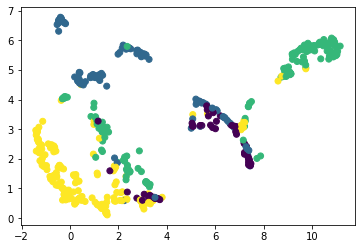

In [26]:
import umap
import matplotlib.pyplot as plt

ims=train_X
labels=train_ground

X_valid_compressed = conv_encoder.predict(ims)
X_valid_compressed = X_valid_compressed.reshape(515, 576)

#kmeans = KMeans(n_clusters=4, random_state=0).fit(imstack)

n_neighbors=20
min_dist=0.0
n_components=2
metric='euclidean'
#metric='canberra'
#metric='mahalanobis'

fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        verbose=True
    )
embedding = fit.fit_transform(X_valid_compressed);

plt.scatter(embedding[:,0], embedding[:,1],c=labels)
plt.show()